In [1]:
import pandas as pd
import xgboost as xgb
import sys,random
import pickle
import os
import numpy as np

In [2]:
if not os.path.exists('unlabel_preds'):
    os.mkdir('unlabel_preds')
if not os.path.exists('unlabel_model'):
    os.mkdir('unlabel_model')
if not os.path.exists('unlabel_featurescore'):
    os.mkdir('unlabel_featurescore')

In [3]:
train_x_d_cols = pd.read_csv('./rank_d_feature_score.csv')
train_x_d_cols = list(train_x_d_cols.iloc[10:810].feature)

In [5]:
%%time
#load data
train_x_date = pd.read_csv('../../preprocess_data/train_x_date.csv').drop(columns=['id'])
train_x_null = pd.read_csv('../../preprocess_data/train_x_null.csv').drop(columns=['id'])
train_x_int = pd.read_csv('../../preprocess_data/train_x_int_filter.csv').drop(columns=['id']) 
train_x_d = pd.read_csv('../../preprocess_data/train_x_float_rank_d.csv',usecols=train_x_d_cols)
train_x_nd = pd.read_csv('../../preprocess_data/train_x_float_rank_nd.csv').drop(columns=['id'])
train_x = pd.concat([train_x_date,train_x_null,train_x_int,train_x_d,train_x_nd],axis=1,ignore_index=True,copy=False)

train_cols = list(train_x_date.columns) +\
            list(train_x_null.columns) +\
            list(train_x_int.columns) +\
            list(train_x_d.columns) + \
            list(train_x_nd.columns)
train_x.columns = train_cols

# 剩余的6w多条数据本来是无标签的，但是我们在数据预处理的时候对其进行了打标
unlabel_date = pd.read_csv('../../preprocess_data/unlabel_x_date.csv')
unlabel_null = pd.read_csv('../../preprocess_data/unlabel_x_null.csv').drop(columns=['id'])
unlabel_int = pd.read_csv('../../preprocess_data/unlabel_x_int_filter.csv').drop(columns=['id'])
unlabel_d = pd.read_csv('../../preprocess_data/unlabel_x_float_rank_d.csv',usecols=train_x_d_cols)
unlabel_nd = pd.read_csv('../../preprocess_data/unlabel_x_float_rank_nd.csv').drop(columns=['id'])
unlabel = pd.concat([unlabel_date,unlabel_null,unlabel_int,unlabel_d,unlabel_nd],axis=1,ignore_index=True,copy=False)
unlabel_cols = list(unlabel_date.columns) + \
            list(unlabel_null.columns) + \
            list(unlabel_int.columns) + \
            list(unlabel_d.columns) + \
            list(unlabel_nd.columns)
unlabel.columns = unlabel_cols

CPU times: user 17 s, sys: 708 ms, total: 17.7 s
Wall time: 20.9 s


In [15]:
# 把已打标的数据加入训练集
unlabel_y = pd.read_csv('unlabel_y.csv')
unlabel_merge = pd.merge(unlabel_y, unlabel, how = 'inner', on='id', copy=False)
unlabel_merge = unlabel_merge.drop(columns=['id','label'])

# train_ay
train_y = pd.read_csv('../../preprocess_data/train_y_33465.csv')
unlabel_y = unlabel_y[['label']]
train_ay = pd.concat([train_y,unlabel_y],axis=0,ignore_index=True,copy=False)
# train_ax
train_ax = pd.concat([train_x,unlabel_merge],axis=0,ignore_index=True,copy=False)
dtrain = xgb.DMatrix(train_ax.values, feature_names=train_ax.columns, label=train_ay.values)
print('正负样本不均衡',train_ay.label.value_counts().to_dict())

正负样本不均衡 {0.0: 37921, 1.0: 5525}


In [7]:
valid_date = pd.read_csv('../../preprocess_data/valid_date.csv')
valid_null = pd.read_csv('../../preprocess_data/valid_null.csv').drop(columns=['id'])
valid_int = pd.read_csv('../../preprocess_data/valid_int_filter.csv').drop(columns=['id'])
valid_d = pd.read_csv('../../preprocess_data/valid_float_rank_d.csv',usecols=train_x_d_cols)
valid_nd = pd.read_csv('../../preprocess_data/valid_float_rank_nd.csv').drop(columns=['id'])
valid = pd.concat([valid_date,valid_null,valid_int,valid_d,valid_nd],axis=1,ignore_index=True,copy=False)
valid_cols = list(valid_date.columns) + \
            list(valid_null.columns) + \
            list(valid_int.columns) + \
            list(valid_d.columns) + \
            list(valid_nd.columns)
valid.columns = valid_cols
# pd.concat后特征名没有了，变成数字了
valid_id = valid.id
valid = valid.drop(columns=['id'])
dvalid = xgb.DMatrix(valid.values, feature_names=valid.columns)

## 本地交叉验证

In [1]:
params={
    'booster':'gbtree',
    'objective': 'binary:logistic',
    'early_stopping_rounds':100,
    'scale_pos_weight': float(len(train_ay)-np.sum(train_ay.values))/float(np.sum(train_ay.values)),  # 负例样本除以正例样本
    'eval_metric': 'auc',
    'gamma':1,
    'max_depth':6,
    'lambda':1,
    'subsample':0.9,
    'colsample_bytree':0.9,
    'min_child_weight':1, 
    'eta': 0.04,
    'seed':1080,
    'nthread':16
        }
result = xgb.cv(params,dtrain,num_boost_round=800,nfold=5,shuffle=True,verbose_eval=True)

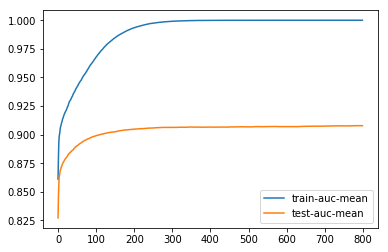

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
result[['train-auc-mean','test-auc-mean']].plot()

## 训练+预测

In [17]:
def pipeline(dtrain,dtest,test_id,iteration,random_seed,gamma,max_depth,lambd,subsample,colsample_bytree,min_child_weight):
    if max_depth==6:
        num_boost_round = 400
    elif max_depth==7:
        num_boost_round = 350
    elif max_depth==8:
        num_boost_round = 300
    
    params={
    'booster':'gbtree',
    'objective': 'binary:logistic',
    'early_stopping_rounds':100,
    'scale_pos_weight': float(len(train_ay)-np.sum(train_ay.values))/float(np.sum(train_ay.values)),  # 负例样本除以正例样本
    'eval_metric': 'auc',
    'gamma':gamma,
    'max_depth':max_depth,
    'lambda':lambd,
    'subsample':subsample,
    'colsample_bytree':colsample_bytree,
    'min_child_weight':min_child_weight, 
    'eta': 0.04,
    'seed':random_seed,
    'nthread':16
        }
    watchlist  = [(dtrain,'train_ax')]
    model = xgb.train(params,dtrain,num_boost_round=num_boost_round,evals=watchlist)
    model.save_model('./unlabel_model/xgb{0}.model'.format(iteration))
    
    #predict test set
    test_y = model.predict(dtest)
    test_result = pd.DataFrame(test_id,columns=["id"])
    test_result['score'] = test_y
    test_result.to_csv("./unlabel_preds/xgb{0}.csv".format(iteration),index=None,encoding='utf-8')
    
    #get feature score
    feature_score = model.get_fscore()
    feature_score = sorted(feature_score.items(), key=lambda x:x[1],reverse=True)
    fs = []
    for (key,value) in feature_score:
        fs.append("{0},{1}\n".format(key,value))
    
    with open('./unlabel_featurescore/feature_score_{0}.csv'.format(iteration),'w') as f:
        f.writelines("feature,score\n")
        f.writelines(fs)
    

In [2]:
%%time
random_seed = list(range(0,10000,25))
gamma = [i/1000.0 for i in range(100,200,2)]
max_depth = [6,7,8]
lambd = list(range(200,400,2))
subsample = [i/1000.0 for i in range(600,700,2)]
colsample_bytree = [i/1000.0 for i in range(250,350,2)]
min_child_weight = [i/1000.0 for i in range(200,300,2)]
random.shuffle(random_seed)
random.shuffle(gamma)
random.shuffle(max_depth)
random.shuffle(lambd)
random.shuffle(subsample)
random.shuffle(colsample_bytree)
random.shuffle(min_child_weight)

with open('params.pkl','wb') as f:
    pickle.dump((random_seed,gamma,max_depth,lambd,subsample,colsample_bytree,min_child_weight),f)

#to reproduce my result, uncomment following lines
"""
with open('params_for_reproducing.pkl','rb') as f:
    random_seed,gamma,max_depth,lambd,subsample,colsample_bytree,min_child_weight = pickle.load(f)    
"""

for i in range(36):
    pipeline(dtrain,dvalid,valid_id,i,random_seed[i],gamma[i],max_depth[i%3],lambd[i],subsample[i],colsample_bytree[i],min_child_weight[i])